In [16]:
%matplotlib inline
%config InlineBackend.figure_format="retina"
import numpy as np
import pandas as pd
from keras.models import load_model
import torch
import os

In [ ]:
#Commented runs use these to run other notebooks (genius.ipynb not included because the lyrics are saved)
# %run processing.ipynb
# %run bert.ipynb

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
%run mrs.ipynb

# of rows of Song Data: 50683
# of unique songs: 50683
# of rows of User Listening Data: 806745
# of unique users: 25343
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50683 entries, 0 to 50682
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          50683 non-null  object 
 1   name              50683 non-null  object 
 2   artist            50683 non-null  object 
 3   spotify_id        50683 non-null  object 
 4   tags              49556 non-null  object 
 5   danceability      50683 non-null  float64
 6   energy            50683 non-null  float64
 7   loudness          50683 non-null  float64
 8   mode              50683 non-null  int64  
 9   speechiness       50683 non-null  float64
 10  acousticness      50683 non-null  float64
 11  instrumentalness  50683 non-null  float64
 12  liveness          50683 non-null  float64
 13  valence           50683 non-null  float64
 14  tempo        

In [19]:
#Note that the bert model and the mrs model need to run before this

x_test = np.load("misc/x_test.npy")
y_test = np.load("misc/y_test.npy")
model = load_model("misc/mae_optimized_model.keras")
lyrics_embeddings_csv = pd.read_csv('misc/lyrics_embeddings.csv')
lyrics_embeddings_3d_csv = pd.read_csv('misc/lyrics_embeddings_3d.csv')
distance_frame = pd.read_csv('misc/distance_frame.csv')
dataset = pd.read_csv("misc/processed_music_info_extended.csv")
distance_frame = distance_frame.drop(['Unnamed: 0'], axis=1)

In [20]:
lyrics_embeddings, lyrics_embeddings_3d = get_embeddings(lyrics_embeddings_csv, lyrics_embeddings_3d_csv)

In [21]:
compare_spotify = x_test[-10:, 0:5, 3:].astype(np.float64)
spotify_data = x_test[-10:,0:5,2]
spotify_input_names = x_test[-10:,0:5,1]

x_info = x_test[:,:,:3]
y_info = x_test[:,:,:3]
x_hidden_features = x_test[:, 15:, 3:].astype(np.float64)
x_hidden_names = x_test[:, 15:, :3]
x_input = x_test[:, :15, 3:].astype(np.float64)
y_hidden = y_test[:, 15:, 3:].astype(np.float64)


In [22]:
print(x_input[0])

[[ 8.4800e-02  2.1200e-01 -1.1406e+01  3.6900e-02  2.5100e-01  6.4600e-01
   7.9600e-02  5.7200e-02]
 [ 5.1500e-01  8.7100e-01 -4.1130e+00  3.6700e-02  5.8500e-04  0.0000e+00
   8.7700e-02  4.9800e-01]
 [ 3.2900e-01  5.3800e-01 -1.0044e+01  3.0000e-02  4.7800e-01  8.6400e-02
   7.0500e-02  2.6400e-01]
 [ 5.1700e-01  5.3900e-01 -1.0148e+01  3.4500e-02  4.6200e-01  6.3900e-01
   7.0200e-02  3.1800e-01]
 [ 5.8100e-01  4.6800e-01 -1.5763e+01  3.1400e-02  2.5100e-02  8.4500e-02
   8.3100e-02  4.9000e-01]
 [ 4.2200e-01  8.2800e-01 -6.5610e+00  2.7700e-02  8.2600e-03  5.0700e-03
   1.5800e-01  5.2300e-01]
 [ 5.6800e-01  7.9400e-01 -4.9760e+00  2.9600e-02  3.9700e-03  1.3500e-03
   3.7300e-01  5.6300e-01]
 [ 2.8800e-01  9.6700e-01 -4.2670e+00  9.4700e-02  6.1600e-04  7.4100e-01
   9.4000e-01  4.4900e-01]
 [ 6.2100e-01  4.9700e-01 -1.0026e+01  2.7000e-02  3.9600e-01  2.3600e-06
   3.3800e-01  7.0200e-01]
 [ 4.8100e-01  6.0300e-01 -6.5900e+00  2.8000e-02  1.6600e-01  3.2100e-02
   1.0900e-01  2.

In [31]:
POTENTIAL_N = 50
TEST_SIZE = 50


results = []
for i in range(0, TEST_SIZE):
    predicted = predict_sample(x_input[i], model)
    recommendation = pipeline_helper(distance_frame, predicted, POTENTIAL_N, lyrics_embeddings, dataset)  
    recommendation = recommendation.head(5)
    recommendation_df = recommendation.drop("artist", axis=1)
    
    df1 = pd.DataFrame(x_hidden_names[0], columns=['ID', 'name', 'Code'])
    df1 = df1.drop(['ID', 'Code'], axis=1)

    df2 = pd.DataFrame(x_hidden_features[0], columns=['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7', 'Feature8'])

    combined_df = pd.concat([df1, df2], axis=1)
    
    score = calculate_score(recommendation_df, combined_df)
    results.append(score)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[8 9 7 6 1 5 3 2 0 4]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[6 8 3 4 7 5 9 2 0 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[9 5 3 4 8 2 7 6 1 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[8 9 7 6 4 5 2 3 0 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[9 4 5 8 7 6 1 2 3 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[5 7 9 3 2 1 4 8 0 6]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[9 7 6 8 1 0 3 2 5 4]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[9 8 6 4 5 3 2 7 0 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[9 6 5 4 7 8 0 1 2 3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[9 6 7 5 4 2 3 8 0 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[9 8 5 3 1 6 2 7 4 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[7 8 6 5 4 9 2 1 3 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[6 8 7 5 4 2 3 9 0 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[8 9 7 5 4 3 6 0 1 2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[6 9 5 2 0 8 1 7 4 3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[8 6 5 4 3 2 9 7 0 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[9

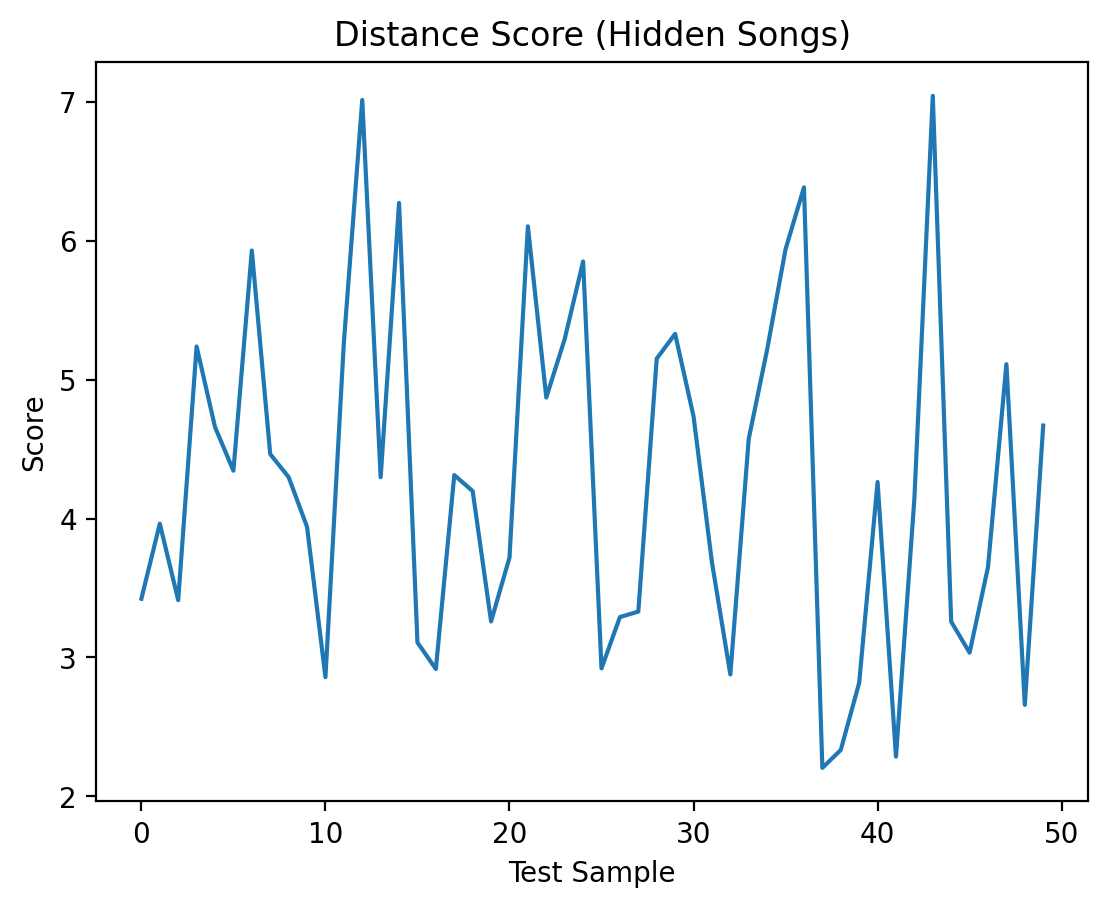

In [32]:

results1 = [np.mean(i) for i in results]
import matplotlib.pyplot as plt
plt.plot(results1)
plt.ylabel('Score')
plt.xlabel('Test Sample')
plt.title('Distance Score (Hidden Songs)')
plt.show()

In [34]:
christina_songs = [[0.654,0.924,-6.28,0.0406,0.00556,0.144,0.331,0.718], [0.554,0.49,-8.046,0.0457,0.0168,0.000534,0.136,0.513], 
                    [0.415,0.867,-5.497,0.0387,5.69e-05,0.000192,0.0883,0.36], [0.597,0.812,-12.062,0.0315,0.0219,0.00106,0.102,0.823], [0.517,0.206,-12.233,0.0421,0.924,0.0,0.118,0.489]]

c_predicted = predict_sample(christina_songs, model)
christina_recs = pipeline_helper(distance_frame, c_predicted, POTENTIAL_N, lyrics_embeddings, dataset) 
christina_recs

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
[9 4 6 3 5 8 1 7 2 0]


,name,artist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence
542,Soma,The Strokes,0.499,0.706,-7.335,0.0302,0.074700,0.002890,0.0753,0.483
3269,Electricity,The Avalanches,0.529,0.771,-7.403,0.0645,0.089900,0.046300,0.1970,0.421
17412,2000 Miles,The Pretenders,0.529,0.723,-7.331,0.0255,0.013900,0.003780,0.1350,0.574
25398,Electric Alice,Grinderman,0.528,0.802,-7.319,0.0280,0.000147,0.013000,0.1450,0.474
26560,Relention,Katatonia,0.556,0.647,-7.479,0.0322,0.005210,0.011300,0.1320,0.389
29272,Fallen Icons,Delerium,0.502,0.714,-7.451,0.0260,0.262000,0.015300,0.1310,0.523
30498,Lightning,Dispatch,0.627,0.603,-7.468,0.0619,0.212000,0.002560,0.0905,0.484
31739,Different Now,Chastity Belt,0.648,0.681,-7.470,0.0295,0.103000,0.001020,0.1030,0.364
37068,Better Days Will Come,Tahiti 80,0.543,0.777,-7.426,0.0277,0.000747,0.007450,0.1450,0.558
50101,George's Helper,Pete Murray,0.653,0.613,-7.387,0.0259,0.068700,0.000216,0.0997,0.381


In [35]:
tyler_songs = [[0.367,0.919,-4.218,0.0574,4.23e-05,0.000489,0.0603,0.301], [0.406,0.953,-5.74,0.0473,6.48e-06,0.000407,0.0911,0.307],
                [0.528,0.864,-4.663,0.0417,0.023,1.68e-05,0.099,0.278], [0.55,0.596,-8.214,0.134,0.162,0.00481,0.0805,0.253], [0.58,0.868,-5.461,0.0423,0.192,0.115,0.108,0.765]]

t_predicted = predict_sample(tyler_songs, model)
tyler_recs = pipeline_helper(distance_frame, t_predicted, POTENTIAL_N, lyrics_embeddings, dataset) 
tyler_recs

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[7 4 8 3 9 1 6 0 2 5]


,name,artist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence
4723,Havana Gang Brawl,The Zutons,0.489,0.893,-6.011,0.0481,0.077100,0.000012,0.1360,0.450
16937,Accident & Emergency,Patrick Wolf,0.567,0.893,-6.058,0.0709,0.063800,0.041400,0.1480,0.342
25689,Fresh Born,Deerhoof,0.628,0.839,-6.057,0.0490,0.119000,0.023700,0.1780,0.396
27162,That's Enough,Dark New Day,0.514,0.726,-5.942,0.0652,0.000221,0.000000,0.1340,0.397
28318,Grey Day,Madness,0.521,0.728,-6.117,0.0332,0.045000,0.000077,0.1310,0.547
31711,La Ferrassie,Tokyo Police Club,0.503,0.707,-6.114,0.0294,0.066100,0.032800,0.1070,0.432
38169,Boom Box,Institute,0.514,0.757,-5.965,0.0462,0.001410,0.000113,0.0587,0.374
42573,With My Eyes Closed,The Raveonettes,0.455,0.715,-6.054,0.0265,0.034800,0.002270,0.1480,0.462
44624,Jesus Christ Superstar,Laibach,0.439,0.915,-6.023,0.0534,0.051000,0.000534,0.1620,0.501
48977,Break You Apart,Jesus On Extasy,0.610,0.790,-6.145,0.0404,0.045100,0.000081,0.0914,0.431


### Spotify API Evaluation
Get recommendations from Spotify by passing in minimum and maximum feature values, and compare the songs to our recommended playlist.

In [36]:
from spotify import SpotifyAPI
from dotenv import load_dotenv
# Get the input playlist
# Traverse along each song in playlist and preserve min max of feature values and 
# Store in list that gets passed to parameters for Spotify APIcommendations

# input_playlist = og_songs
# features = dict()
# feature_names = ["danceability","energy","loudness","speechiness","acousticness","instrumentalness","liveness", "valence"]

# for feature in feature_names:
#     features["min_" + feature] = input_playlist[feature].min()
#     features["max_" + feature] = input_playlist[feature].max()

# features["seed_genres"] = input_playlist['tags'].iloc[0].split(',')[:3]
# features["seed_genres"] = ','.join(features["seed_genres"])
# features

In [38]:
print(compare_spotify[0])
print(spotify_data[0])

[[ 5.350e-01  9.400e-01 -9.489e+00  5.110e-02  1.460e-04  1.380e-01
   1.620e-01  2.670e-01]
 [ 5.530e-01  9.290e-01 -5.917e+00  1.160e-01  5.370e-03  9.130e-01
   1.030e-01  6.390e-01]
 [ 5.650e-01  7.650e-01 -7.459e+00  5.580e-02  1.510e-04  8.180e-01
   1.090e-01  1.800e-01]
 [ 4.490e-01  9.810e-01 -5.900e+00  7.280e-02  3.520e-03  8.210e-01
   5.410e-01  4.560e-01]
 [ 1.570e-01  9.990e-01 -3.940e+00  5.810e-01  9.890e-04  8.130e-01
   5.340e-01  7.390e-02]]
['2uuLEep2OyG8eAmlwt7cCl' '0fLb1BuFH4ld4gCpUYSSah'
 '1cpqLXwSvqPbU3Mgv14dpK' '28vdSqTMWRPxXTCiXVw0ax'
 '2qEwLfEmzJxdNhsQMT3hk1']


In [39]:
print(spotify_input_names[0])

["Everything's Ruined" 'Echo Sam' 'Bontempi Latin' 'Tonebank Computer'
 '2 Morro Morro Land']


In [44]:
our_results = []
for compare_playlist in compare_spotify:    
    predicted = predict_sample(compare_playlist, model)
    our_recs = pipeline_helper(distance_frame, predicted, POTENTIAL_N, lyrics_embeddings, dataset)
    our_recs = our_recs.drop("artist", axis=1) 
    our_results.append(our_recs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[8 2 5 1 7 9 6 4 0 3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[5 8 6 4 7 3 9 0 1 2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[8 9 4 5 7 6 3 2 1 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[7 9 5 4 3 6 8 0 1 2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[5 6 7 8 3 2 4 9 0 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[8 2 9 0 1 4 3 6 5 7]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[5 8 3 7 9 4 2 6 0 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[7 8 6 5 4 3 2 1 9 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[8 9 4 3 5 7 0 6 1 2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[8 9 7 6 5 4 2 1 3 0]


In [41]:
env_path = os.path.join('misc', '.env')
load_dotenv(dotenv_path=env_path)
SPOTIFY_CREDS = [os.getenv('SPOTIFY_CLIENT_ID'), 
                os.getenv('SPOTIFY_CLIENT_SECRET')]

if not all(SPOTIFY_CREDS):
        print("Please set the SPOTIFY_CLIENT_ID and SPOTIFY_CLIENT_SECRET environment variables")
        exit(1)

spotify = SpotifyAPI(*SPOTIFY_CREDS)
SPOTIFY_CREDS

['1fa1ca9358074af48f6230e7b13c0737', '880a92c5194f496b929d0d4d96ec3a59']

In [42]:
spotify_results = []
for spot_playlist in spotify_data:
    recs_from_spotify = spotify.get_recommendations(seed_tracks=spot_playlist.tolist(), limit=10)
    recs_from_spotify = recs_from_spotify.loc[:, ['name', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',
                                'liveness', 'valence']]
    spotify_results.append(recs_from_spotify)

In [45]:
score_res = []
for j in range(len(spotify_results)):
    score_res.append(calculate_score(our_results[j], spotify_results[j]))

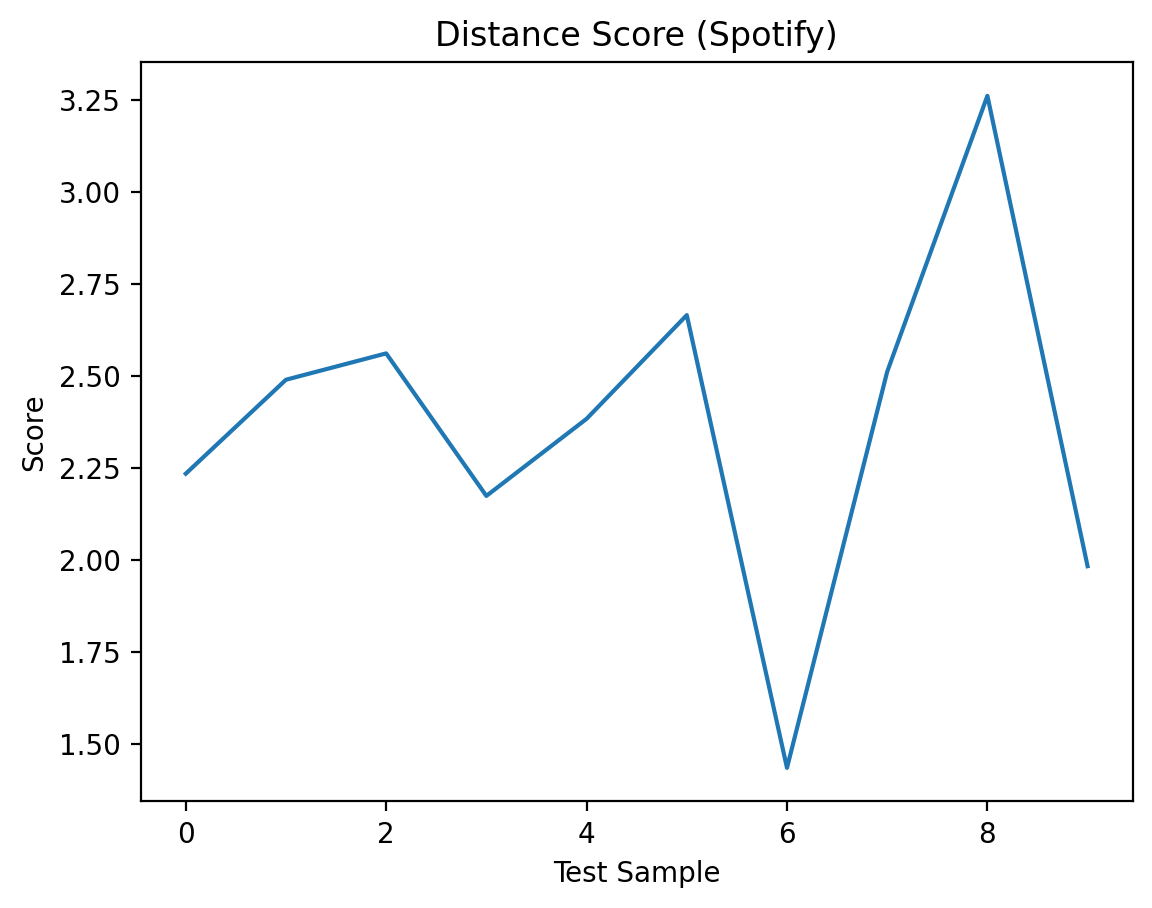

In [46]:
res = [np.mean(i) for i in score_res]
# plot res
# set the y axis max to 10
plt.plot(res)
plt.ylabel('Score')
plt.xlabel('Test Sample')
plt.title('Distance Score (Spotify)')
plt.show()

